## Building a 'Bag of Words' Clustering Model

 - 20 newsgroups
 - kmeans
 - LSA (latent semantic analysis)

In [1]:
import pandas as pd
import numpy as np
from time import time
from matplotlib import pyplot as plt
%matplotlib inline

# make sure we display all the columns
pd.set_option('display.max_columns', 25)

from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction import text
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics
from sklearn.cluster import KMeans

def fetchInputs():
    print "Loading 20 newsgroups dataset"
    dataset = fetch_20newsgroups(subset='all', categories=None, shuffle=True, random_state=42)
    labels = dataset.target
    true_k = np.unique(labels).shape[0]
    
    print "%d documents" % len(dataset.data)
    print "%d categories" % len(dataset.target_names)
    print
    return dataset.data, labels, true_k
    

def vectorizeInputs(n, min_df, max_df, data):
    print "Extracting features from the training dataset using a tf-idf vectorizer"
    t0 = time()
    
    more_stop_words = set()
    with open('SuperSmartStopList.txt', 'rb') as fp:
        for line in fp:
            more_stop_words.add(line.strip())
    
    vectorizer = text.TfidfVectorizer(
        stop_words=text.ENGLISH_STOP_WORDS.union(more_stop_words),
        max_features=n, 
        max_df=max_df, 
        min_df=min_df, 
        sublinear_tf=True,
        decode_error='ignore', 
        lowercase=True)
    
    x = vectorizer.fit_transform(data).todense()
    terms = vectorizer.get_feature_names()

    print "done in %fs" % (time() - t0)
    print "n_samples: %d, n_features: %d" % x.shape
    print
    return x, terms


def performLSA(n, x, normalize=True, verbose=True):
    if not n:
        if verbose:
            print "Not performing dimensionality reduction. n=%d" % n
            print
        return x, None
    
    if verbose:
        print "Performing dimensionality reduction using LSA n=%d" % n
    t0 = time()
    # Vectorizer results are normalized, which makes KMeans behave as
    # spherical k-means for better results. Since LSA/SVD results are
    # not normalized, we have to redo the normalization.
    svd = TruncatedSVD(n)
    if normalize:
        normalizer = Normalizer(copy=False)
        lsa = make_pipeline(svd, normalizer)
    else:
        lsa = svd
    x = lsa.fit_transform(x)
    if verbose:
        print "done in %fs" % (time() - t0)

    explained_variance = svd.explained_variance_ratio_.sum()
    if verbose:
        print "Explained variance of the SVD step: {}%".format(int(explained_variance * 100))
        print  
    return x, svd

def performClustering(num_clusters, data, verbose=True):
    # Note: as k-means is optimizing a non-convex objective function, it will likely end up 
    # in a local optimum. Several runs with independent random init might be necessary to 
    # get a good convergence.
    km = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=100, n_init=1, verbose=verbose)
    print "Clustering sparse data with %s" % km
    print
    t0 = time()
    km.fit(data)
    
    print "done in %0.3fs" % (time() - t0)
    print
    return km



//anaconda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [2]:
# Preprocess documents with latent semantic analysis.
n_components = 100
# Maximum number of features (dimensions) to extract from text
n_features = 10000
# Minimum document frequency
min_df = 0.005
# Maximum document frequency
max_df = 0.95

# raw inputs
data, labels, true_k = fetchInputs()

# tf-idf vectorization
# 
# It can be noted that k-means is very sensitive to feature scaling and 
# that in this case the IDF weighting helps improve the quality of the clustering
# by quite a lot as measured against the “ground truth” provided by the class label 
# assignments of the 20 newsgroups dataset.
_X, feature_names = vectorizeInputs(n_features, min_df, max_df, data)

# latent sematic analysis is used to reduce dimensionality 
# and discover latent patterns in the data.
r_X, r_svd = performLSA(n_components, _X)


Loading 20 newsgroups dataset
18846 documents
20 categories

Extracting features from the training dataset using a tf-idf vectorizer
done in 5.351817s
n_samples: 18846, n_features: 3320

Performing dimensionality reduction using LSA n=100
done in 2.311101s
Explained variance of the SVD step: 18%



In [3]:
# for now, set the number of clusters equal to the ground truth
k = true_k

# do clustering
primary_cluster_model = performClustering(k, r_X)

# This improvement is not visible in the Silhouette Coefficient which is small 
# for both as this measure seem to suffer from the phenomenon called 
# “Concentration of Measure” or “Curse of Dimensionality” for high dimensional 
# datasets such as text data. Other measures such as V-measure and Adjusted Rand 
# Index are information theoretic based evaluation scores: as they are only based 
# on cluster assignments rather than distances, hence not affected by the curse of dimensionality.
print "k: %s" % k
print "Homogeneity: %0.3f" % metrics.homogeneity_score(labels, primary_cluster_model.labels_)
print "Completeness: %0.3f" % metrics.completeness_score(labels, primary_cluster_model.labels_)
print "V-measure: %0.3f" % metrics.v_measure_score(labels, primary_cluster_model.labels_)
print "Adjusted Rand-Index: %.3f" % metrics.adjusted_rand_score(labels, primary_cluster_model.labels_)
print "Silhouette Coefficient: %0.3f" % metrics.silhouette_score(r_X, primary_cluster_model.labels_, sample_size=1000)
print

print "Top terms per cluster:"
if n_components:
    original_space_centroids = r_svd.inverse_transform(primary_cluster_model.cluster_centers_)
    order_centroids = original_space_centroids.argsort()[:, ::-1]
else:
    order_centroids = primary_cluster_model.cluster_centers_.argsort()[:, ::-1]

for i in range(k):
    print "Cluster %d:" % i,
    for ind in order_centroids[i, :10]:
        print ' %s' % feature_names[ind],
    print
print

Clustering sparse data with KMeans(copy_x=True, init='k-means++', max_iter=100, n_clusters=20, n_init=1,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=True)

Initialization complete
Iteration  0, inertia 21559.424
Iteration  1, inertia 13542.084
Iteration  2, inertia 13244.214
Iteration  3, inertia 13135.794
Iteration  4, inertia 13079.117
Iteration  5, inertia 13056.713
Iteration  6, inertia 13041.974
Iteration  7, inertia 13029.794
Iteration  8, inertia 13021.711
Iteration  9, inertia 13018.941
Iteration 10, inertia 13017.649
Iteration 11, inertia 13016.886
Iteration 12, inertia 13016.564
Iteration 13, inertia 13016.452
Iteration 14, inertia 13016.371
Iteration 15, inertia 13016.315
Iteration 16, inertia 13016.295
Iteration 17, inertia 13016.277
Iteration 18, inertia 13016.253
Iteration 19, inertia 13016.241
Iteration 20, inertia 13016.237
Iteration 21, inertia 13016.234
Iteration 22, inertia 13016.230
Iteration 23, inertia 13016.228
Converged 

## Plotting Clusters using SVD

Clustering sparse data with KMeans(copy_x=True, init='k-means++', max_iter=100, n_clusters=20, n_init=1,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=False)

done in 0.237s

Clustering sparse data with KMeans(copy_x=True, init='k-means++', max_iter=100, n_clusters=20, n_init=1,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=False)

done in 0.081s



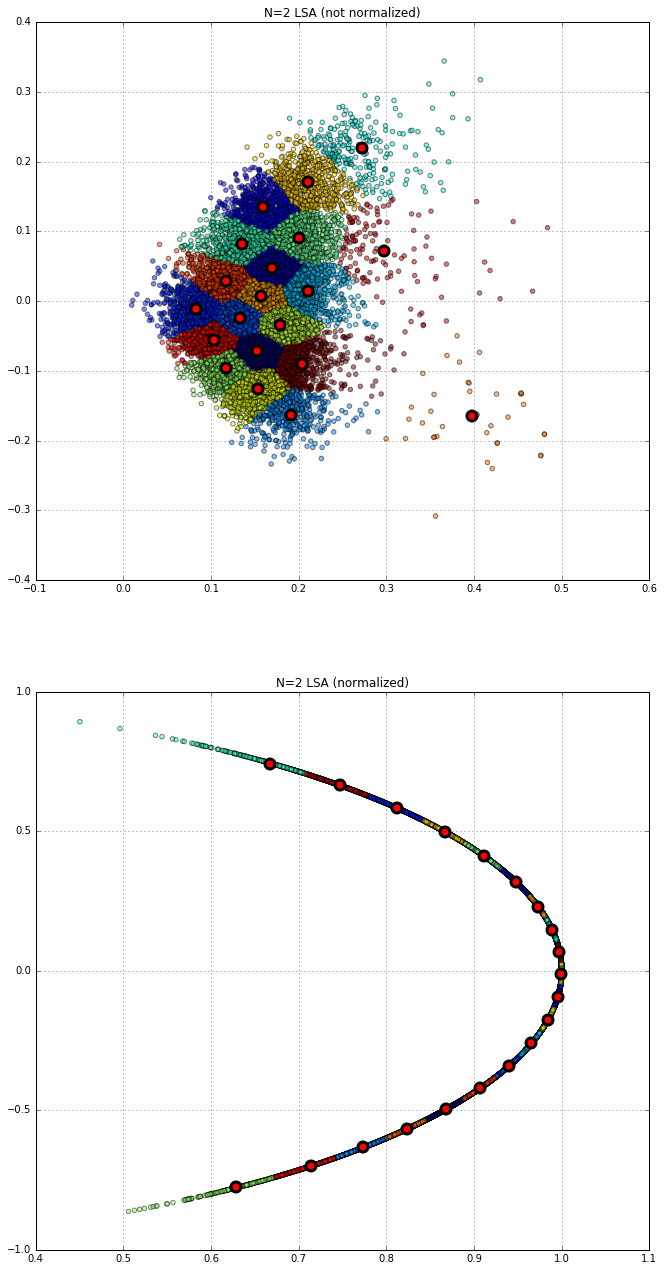

In [4]:
# latent sematic analysis can also be used to produce 
# scatter plots of clusterings
n_X, n_svd = performLSA(2, _X, verbose=False)
g_X, g_svd = performLSA(2, _X, normalize=False, verbose=False)

# graphical clustering (not normalized)
g_km = performClustering(k, g_X, verbose=False)
g_centers2D = g_km.cluster_centers_

# graphical clustering (normalized)
n_km = performClustering(k, n_X, verbose=False)
n_centers2D = n_km.cluster_centers_

fig = plt.figure(figsize=(11,22), tight_layout=False)

ax1 = plt.subplot(211)
ax1.scatter(g_X[:,0], g_X[:,1], c=g_km.labels_, alpha=0.5)
ax1.scatter(g_centers2D[:,0], g_centers2D[:,1], marker='o', s=100, linewidth=3, c='r')
ax1.grid(True)
ax1.set_xlabel('', fontsize=20)
ax1.set_ylabel('', fontsize=20)
# ax1.set_xlim([0,.35])
# ax1.set_ylim([-.3,.5])
ax1.set_title('N=2 LSA (not normalized)')

ax2 = plt.subplot(212)
ax2.scatter(n_X[:,0], n_X[:,1], c=n_km.labels_, alpha=0.5)
ax2.scatter(n_centers2D[:,0], n_centers2D[:,1], marker='o', s=100, linewidth=3, c='r')
ax2.grid(True)
ax2.set_xlabel('', fontsize=20)
ax2.set_ylabel('', fontsize=20)
# ax2.set_ylim([-1,1])
ax2.set_title('N=2 LSA (normalized)')

plt.show()



## Fitting Pocket Data